# XGBoost (Heart Data)

XGBoost는 앙상블(Ensemble) 기법을 구현한 대표적인 알고리즘은 Gradient Boost를 사용하며, Regression, Classification 모두에서 사용가능하다. 성능과 자원의 효율이 좋아 여러 문제에서 좋은 성과를 보여준다. 최근에는 LightGBM, Catboost 같은 보다 나은 모델이 등장하여 현업에서의 사용은 다소 줄어든 상황이다.

**XGBoost의 장점**
- GBM 대비 빠른 수행시간
- 병령 처리로 학습하여 속도가 빠르다.
- 과적합 규제(Regularization)를 포함하고 있어 강한 내구성을 가진다.
- Greedy Algorithm을 활용하여 가지치기(Pruning)하며, 이를 통해 과적합(Overfitting)에서 좀 더 자유롭다.
- CART(Classification And Regression Tree) 앙상블 모델을 사용
- Ealrly Stopping 기능 존재
- 유연성이 좋아 다양한 옵션과 Customizing이 용이하다.
- 결측치(Missing Values)를 내부적으로 처리하여 편리함을 제공

In [51]:
import numpy as np
import pandas as pd
from collections import deque
from time import time
from datetime import timedelta
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## 1. XGBoost (Extream Gradient Boosting) Regression with Hitters Data

## 2. XGBoost (Extream Gradient Boosting) Classification with Heart Data

XGBoost와 Random Forest의 성능을 비교해 본다.

In [2]:
heart_data = pd.read_csv('./data/Heart.csv', index_col=0)
heart_data.head(3)

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes


In [3]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303 entries, 1 to 303
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        303 non-null    int64  
 1   Sex        303 non-null    int64  
 2   ChestPain  303 non-null    object 
 3   RestBP     303 non-null    int64  
 4   Chol       303 non-null    int64  
 5   Fbs        303 non-null    int64  
 6   RestECG    303 non-null    int64  
 7   MaxHR      303 non-null    int64  
 8   ExAng      303 non-null    int64  
 9   Oldpeak    303 non-null    float64
 10  Slope      303 non-null    int64  
 11  Ca         299 non-null    float64
 12  Thal       301 non-null    object 
 13  AHD        303 non-null    object 
dtypes: float64(2), int64(9), object(3)
memory usage: 35.5+ KB


In [4]:
# Null 값 데이터 제거
heart_data = heart_data.dropna()
heart_data.shape

(297, 14)

In [5]:
# X, y갑 분할
X = heart_data[heart_data.columns.difference(['AHD'])]
y = heart_data['AHD']

# 학습, 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(237, 13) (237,)
(60, 13) (60,)


In [6]:
# dummies
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

X_train.head(3)

,Age,Ca,Chol,ExAng,Fbs,MaxHR,Oldpeak,RestBP,RestECG,Sex,Slope,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable
54,44,0.0,219,0,0,188,0.0,130,2,1,1,0,0,1,0,0,1,0
268,59,1.0,218,0,1,134,2.2,126,0,1,2,0,1,0,0,1,0,0
97,59,1.0,239,1,0,142,1.2,110,2,1,2,1,0,0,0,0,0,1


In [7]:
# y데이터 가공
y_train = y_train.apply(lambda x: 1 if x.strip() == 'Yes' else 0)
y_test = y_test.apply(lambda x: 1 if x.strip() == 'Yes' else 0)
y_train

54     0
268    1
97     1
266    1
236    1
      ..
108    1
84     1
18     0
234    0
100    0
Name: AHD, Length: 237, dtype: int64

In [8]:
# XGBoost와 Random Forest의 간단한 비교

# XGBoost 학습 및 스코어링
xgb = XGBClassifier(random_state=9)
xgb.fit(X_train, y_train)
xgb_score = xgb.score(X_test, y_test)

# Random Forest 학습 및 스코어링
rf = RandomForestClassifier(random_state=9)
rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)

print('XGBosst Score: ', xgb_score)
print('RandomForest Score: ', rf_score)

XGBosst Score:  0.8833333333333333
RandomForest Score:  0.8333333333333334


In [28]:
# Confusion Matrix 반환 함수
def _get_confusion_mat(model, _X, _y):
    _y_pred = model.predict(_X)
    confusion_mat = pd.crosstab(_y.values.ravel(), _y_pred, 
                                rownames=['Actual'], 
                                colnames=['Predicted'])
    return confusion_mat

# Confusion Report 반환 함수
def _get_confusion_report(model, _X, _y):
    _y_pred = model.predict(_X)
    return classification_report(_y, _y_pred)

# Confusion Matrix를 그려주는 함수
def print_confusion_mat(model, _X, _y):
    # confusion matrix 산출 
    confusion_mat = _get_confusion_mat(model, _X, _y)
    
    # confusion matrix 시각화
    fig = sns.heatmap(confusion_mat, 
                      annot=True, 
                      fmt='d', 
                      cmap="YlGnBu")
    fig.set_title('Confusion Matrix')
    plt.show()
    
    # 여러 측정지표 확인
    print('\n[Confusion Report]\n\n', _get_confusion_report(model, _X, _y))

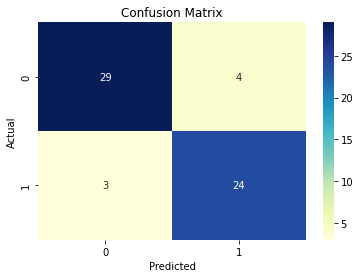


[Confusion Report]

               precision    recall  f1-score   support

           0       0.91      0.88      0.89        33
           1       0.86      0.89      0.87        27

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



In [29]:
# XGBoost Confusion Matrix
print_confusion_mat(xgb, X_test, y_test)

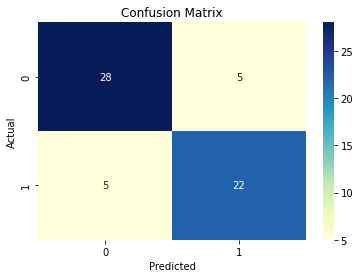


[Confusion Report]

               precision    recall  f1-score   support

           0       0.85      0.85      0.85        33
           1       0.81      0.81      0.81        27

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60



In [30]:
# Random Forest Confusion Matrix
print_confusion_mat(rf, X_test, y_test)

In [64]:
# XGBoost parmeter Geedy Search로 최적화 하기

# 실행 시간 측정
start = time()

# 모델 생성 및 탐색할 파라미터 범주 설정
xgb = XGBClassifier(random_state=9)
parm = {'learning_rate': [0.1, 0.3, 0.5],    # learning rate 값, 높을수록 과적합이 쉽다.
        'n_estimators': [80, 100, 120],      # 생성할 weak learner의 수, learning rate가 낮을 때 n_estimator가 높아야 과적합을 방지한다.
        'max_depth': [4, 6, 8],              # 트리의 maximum depth, 보통 3~10의 값을 가지며 높을수록 복잡도 증가와 과적합이 쉬워진다.
        'gamma': [0, 0.1, 0.5]               # 리프노드의 추가 분할을 결정할 최소손실 감소 값, 높을수록 과적합이 방지된다.
       }

# 최적 파라미터 탐색 및 모델 학습
xgb_greedyCV_acc = GridSearchCV(xgb, param_grid=parm, cv=5, scoring='accuracy')
xgb_greedyCV_acc.fit(X_train, y_train)

print('Best Parm (ACC): ', xgb_greedyCV_acc.best_estimator_)
print('Best Score (ACC): ', xgb_greedyCV_acc.best_score_)

# 실행 시간 측정
print('Time taken: ', round(time() - start, 3))

Best Parm (ACC):  XGBClassifier(learning_rate=0.5, max_depth=8, n_estimators=120, random_state=9)
Best Score (ACC):  0.7890957446808511
Time taken:  13.7


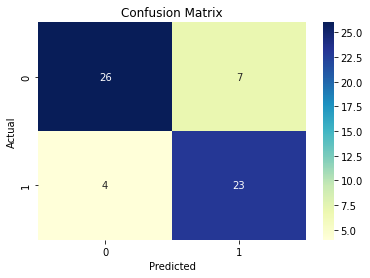


[Confusion Report]

               precision    recall  f1-score   support

           0       0.87      0.79      0.83        33
           1       0.77      0.85      0.81        27

    accuracy                           0.82        60
   macro avg       0.82      0.82      0.82        60
weighted avg       0.82      0.82      0.82        60



In [68]:
#  Confusion Matrix
print_confusion_mat(xgb_greedyCV_acc, X_test, y_test)

In [69]:
# XGBoost parmeter Random Seach로 최적화 하기

# 실행 시간 측정
start = time()

# 최적 파라미터 탐색 및 모델 학습
xgb = XGBClassifier(random_state=9)
xgb_randCV_acc = RandomizedSearchCV(xgb, param_distributions=parm, cv=5, n_iter=20, scoring='accuracy')
xgb_randCV_acc.fit(X_train, y_train)

print('Best Parm (ACC): ', xgb_greedyCV_acc.best_estimator_)
print('Best Score (ACC): ', xgb_greedyCV_acc.best_score_)

# 실행 시간 측정
print('Time taken: ', round(time() - start, 3))

Best Parm (ACC):  XGBClassifier(learning_rate=0.5, max_depth=8, n_estimators=120, random_state=9)
Best Score (ACC):  0.7890957446808511
Time taken:  3.76


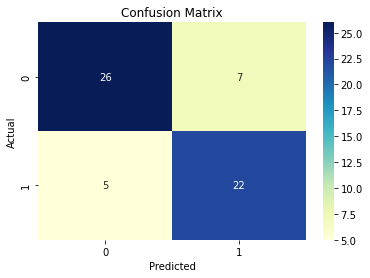


[Confusion Report]

               precision    recall  f1-score   support

           0       0.84      0.79      0.81        33
           1       0.76      0.81      0.79        27

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60



In [70]:
# Random Forest Confusion Matrix
print_confusion_mat(xgb_randCV_acc, X_test, y_test)

<br/>

**결론)**   

Random Search는 Greedy Search보다 빠르고 좋은 결과를 가져오는 경우도 많다. 가급적 Random Search가 좋다. 또한 파라미터의 최적화가 언제나 좋은 결과를 가져오는 것은 아니다.

<br/>

----

**TIP)**   
*XGBoost의 기본 원리*

XGBoost는 Boosting 기법을 사용하고 Boosting 기법은 약한 분류기를 조합하여 보다 높은 정확도를 이끌어내는 기법이다. 예를 들어 어떤 학습기 $M$에 대하여 $Y$를 예측할 확률은 $Y = M_{x_{1}} + error_{(1)}$로 표현 할 수 있는데, error를 좀 더 상세하게 분류 할 수 있는 $G$모델이 있다면 $error_{(1)}$은 $error_{(1)} = G_{x_{2}} + error_{(2)}$로 표현 할 수 있다. 마찬가지로 $error_{(2)}$는 임의의 모델 $H$에 의해 $error_{(2)} = H_{x_{3}} + error_{(3)}$로 표현된다.

결론적으로, $Y$는 아래의 식으로 표현 될 수 있다.  
$Y = M_{x_{1}} + G_{x_{2}} + H_{x_{3}} + error_{(3)}$ $(단, error_{(1)} > error_{(2)} > error_{(3)})$

이는, $M$ 하나의 모델만을 사용할 때 보다는 높은 결과를 얻을 수 있겠지만 같은 비중으로 모델 $M$, $G$, $H$를 처리하게 되면 서로 모델이 간섭하여 좋은 결과를 얻기 힘드므로, 각 모델의 가중치를 반영하고 그 결과는 다음과 같다.   
$Y = W_{1}M_{x_{1}} + W_{2}G_{x_{2}} + W_{3}H_{x_{3}} + error_{(3)}$   

----